In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2e-20

nband = 1100

ng =7

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =300

vstar = 1900

data w_diffuse
     &     /1.55 , 1.55 , 1.55 , 1.55,
     &     1.55 , 1.55 , 1.8/

data wgt
     &     /0.3 , 0.4 , 0.5 , 0.6,
     &     0.7 , 0.85 , 0.9/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

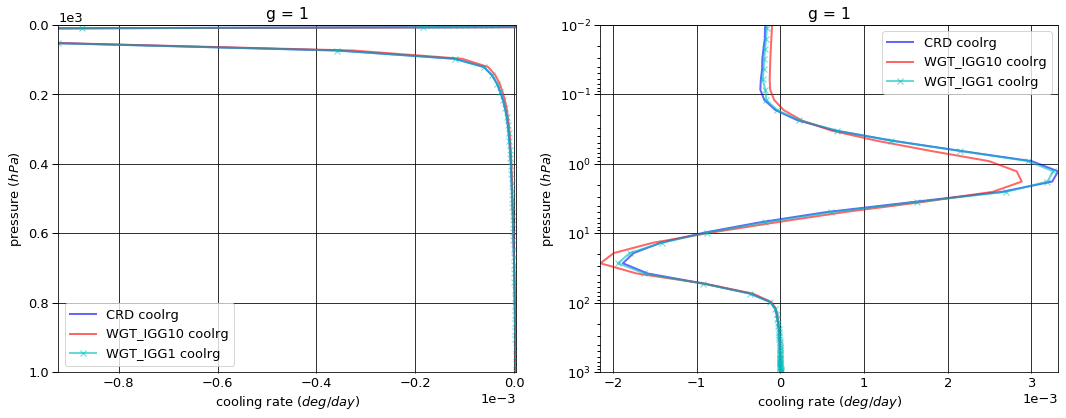

# Figure: cooling rate g-group 2

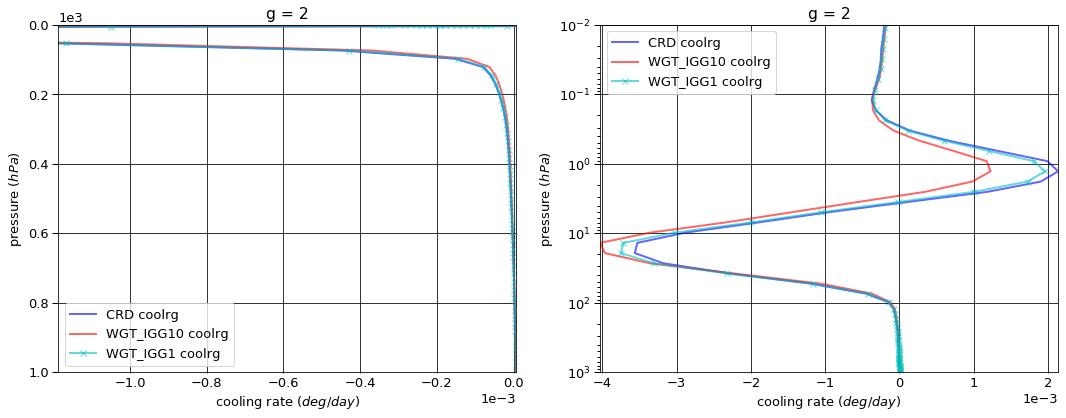

# Figure: cooling rate g-group 3

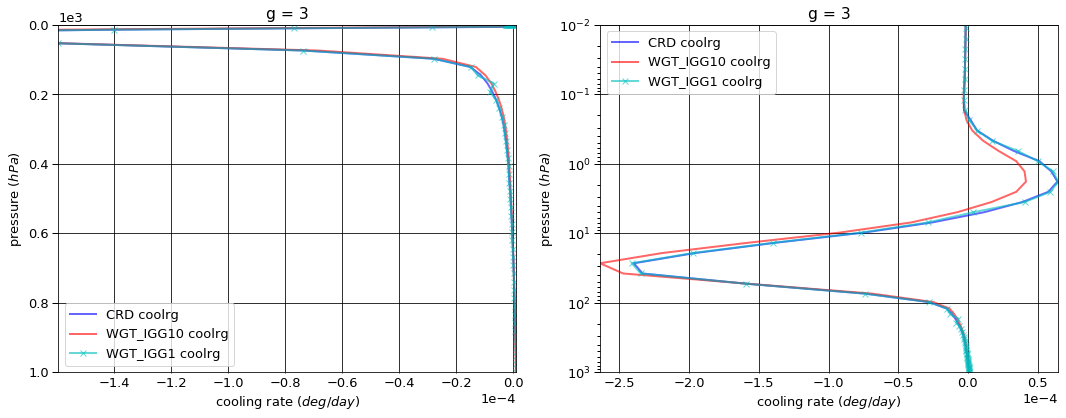

# Figure: cooling rate g-group 4

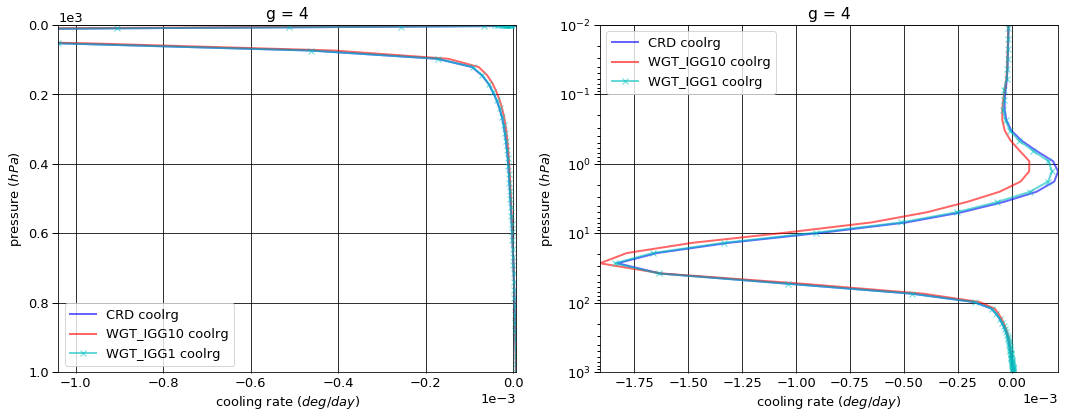

# Figure: cooling rate g-group 5

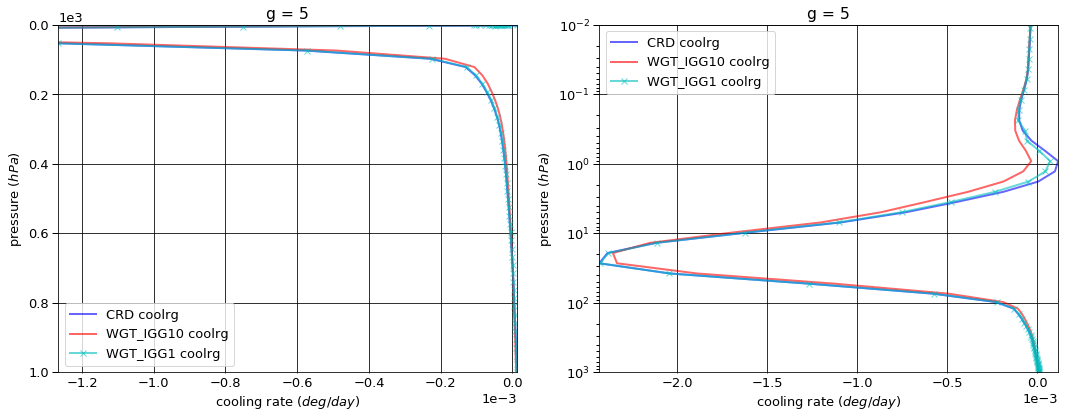

# Figure: cooling rate g-group 6

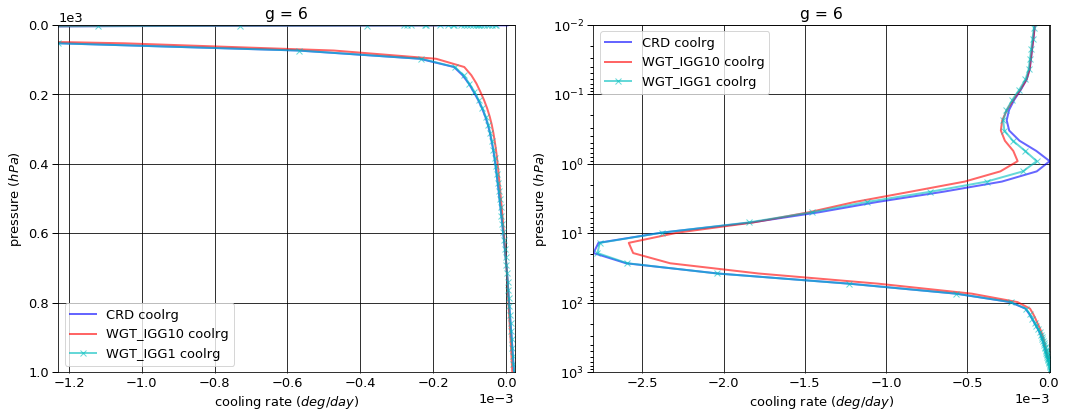

# Figure: cooling rate g-group 7

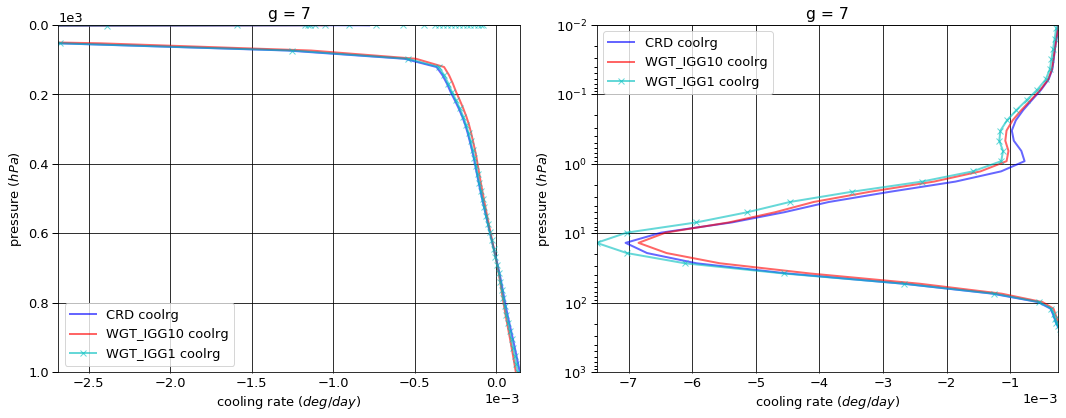

# Figure: cooling rate g-group total

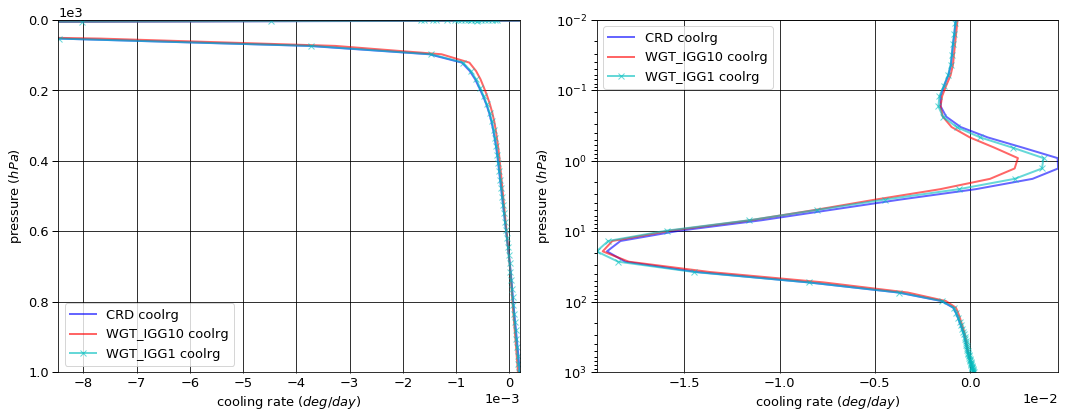

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002045  0.000000 -0.002045
  1013.0   76    -0.012407  0.000570 -0.011837
2 0.0      1     -0.010656  0.000000 -0.010656
  1013.0   76    -0.030043  0.001254 -0.028789
3 0.0      1     -0.000605  0.000000 -0.000605
  1013.0   76    -0.002388  0.000108 -0.002279
4 0.0      1     -0.009758  0.000000 -0.009758
  1013.0   76    -0.022711  0.000791 -0.021921
5 0.0      1     -0.032361  0.000000 -0.032361
  1013.0   76    -0.050420  0.001336 -0.049084
6 0.0      1     -0.073915  0.000000 -0.073915
  1013.0   76    -0.094581  0.001937 -0.092644
7 0.0      1     -7.917474  0.000000 -7.917474
  1013.0   76    -7.972590  0.008953 -7.963637


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001695  0.000000 -0.001695
  1013.0   76    -0.012407  0.000530 -0.011877
2 0.0      1     -0.010051  0.000000 -0.010051
  1013.0   76    -0.030043  0.001245 -0.028797
3 0.0      1     -0.000572  0.000000 -0.000572
  1013.0   76    -0.002388  0.000099 -0.002289
4 0.0      1     -0.009944  0.000000 -0.009944
  1013.0   76    -0.022711  0.000720 -0.021991
5 0.0      1     -0.033786  0.000000 -0.033786
  1013.0   76    -0.050420  0.001150 -0.049270
6 0.0      1     -0.076435  0.000000 -0.076435
  1013.0   76    -0.094581  0.001616 -0.092965
7 0.0      1     -7.921820  0.000000 -7.921820
  1013.0   76    -7.972590  0.007581 -7.965009


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001910  0.000000 -0.001910
  1013.0   76    -0.012407  0.000568 -0.011839
2 0.0      1     -0.010184  0.000000 -0.010184
  1013.0   76    -0.030043  0.001273 -0.028769
3 0.0      1     -0.000597  0.000000 -0.000597
  1013.0   76    -0.002388  0.000108 -0.002279
4 0.0      1     -0.009699  0.000000 -0.009699
  1013.0   76    -0.022711  0.000792 -0.021919
5 0.0      1     -0.032425  0.000000 -0.032425
  1013.0   76    -0.050420  0.001325 -0.049095
6 0.0      1     -0.073967  0.000000 -0.073967
  1013.0   76    -0.094581  0.001929 -0.092652
7 0.0      1     -7.916740  0.000000 -7.916740
  1013.0   76    -7.972590  0.008360 -7.964230


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.498558e-04  0.000000  0.000350
  1013.0   76     0.000000e+00 -0.000040 -0.000040
2 0.0      1      6.053400e-04  0.000000  0.000605
  1013.0   76     0.000000e+00 -0.000008 -0.000008
3 0.0      1      3.313909e-05  0.000000  0.000033
  1013.0   76     0.000000e+00 -0.000009 -0.000009
4 0.0      1     -1.858157e-04  0.000000 -0.000186
  1013.0   76     3.469447e-18 -0.000071 -0.000071
5 0.0      1     -1.425211e-03  0.000000 -0.001425
  1013.0   76     6.938894e-18 -0.000185 -0.000185
6 0.0      1     -2.519950e-03  0.000000 -0.002520
  1013.0   76     0.000000e+00 -0.000322 -0.000322
7 0.0      1     -4.346500e-03  0.000000 -0.004346
  1013.0   76     8.881784e-16 -0.001372 -0.001372


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      1.348315e-04  0.000000e+00  1.348315e-04
  1013.0   76     0.000000e+00 -2.004650e-06 -2.005000e-06
2 0.0      1      4.724000e-04  0.000000e+00  4.724000e-04
  1013.0   76     0.000000e+00  1.964420e-05  1.964400e-05
3 0.0      1      7.615750e-06  0.000000e+00  7.615750e-06
  1013.0   76     0.000000e+00  9.090000e-09  9.100000e-09
4 0.0      1      5.883510e-05  0.000000e+00  5.883510e-05
  1013.0   76     3.469447e-18  1.674000e-06  1.674000e-06
5 0.0      1     -6.408200e-05  0.000000e+00 -6.408200e-05
  1013.0   76     6.938894e-18 -1.101370e-05 -1.101400e-05
6 0.0      1     -5.202000e-05  0.000000e+00 -5.202000e-05
  1013.0   76     0.000000e+00 -8.019000e-06 -8.019000e-06
7 0.0      1      7.343000e-04  0.000000e+00  7.343000e-04
  1013.0   76     8.881784e-16 -5.932197e-04 -5.932000e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.912881e-05
  1001.112500 75     3.877584e-06
2 0.000312    1     -6.617490e-05
  1001.112500 75     7.243896e-06
3 0.000312    1     -4.970759e-07
  1001.112500 75     1.023576e-06
4 0.000312    1     -4.348818e-06
  1001.112500 75     7.168373e-06
5 0.000312    1     -1.070222e-05
  1001.112500 75     1.364809e-05
6 0.000312    1     -2.560426e-05
  1001.112500 75     2.205071e-05
7 0.000312    1     -7.260411e-05
  1001.112500 75     1.443372e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -3.407830e-05
  1001.112500 75     3.089060e-06
2 0.000312    1     -5.767844e-05
  1001.112500 75     5.661735e-06
3 0.000312    1     -4.750013e-07
  1001.112500 75     8.235532e-07
4 0.000312    1     -4.712404e-06
  1001.112500 75     5.710924e-06
5 0.000312    1     -1.110464e-05
  1001.112500 75     1.077902e-05
6 0.000312    1     -2.583758e-05
  1001.112500 75     1.737376e-05
7 0.000312    1     -7.423642e-05
  1001.112500 75     1.200501e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -5.313897e-05
  1001.112500 75     3.877230e-06
2 0.000312    1     -6.079412e-05
  1001.112500 75     7.185286e-06
3 0.000312    1     -4.865672e-07
  1001.112500 75     1.022087e-06
4 0.000312    1     -4.470791e-06
  1001.112500 75     7.111852e-06
5 0.000312    1     -1.095738e-05
  1001.112500 75     1.355906e-05
6 0.000312    1     -2.724334e-05
  1001.112500 75     2.357335e-05
7 0.000312    1     -8.128100e-05
  1001.112500 75     1.325338e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.505051e-05
  1001.112500 75    -7.885240e-07
2 0.000312    1      8.496470e-06
  1001.112500 75    -1.582161e-06
3 0.000312    1      2.207459e-08
  1001.112500 75    -2.000228e-07
4 0.000312    1     -3.635858e-07
  1001.112500 75    -1.457449e-06
5 0.000312    1     -4.024160e-07
  1001.112500 75    -2.869068e-06
6 0.000312    1     -2.333180e-07
  1001.112500 75    -4.676948e-06
7 0.000312    1     -1.632316e-06
  1001.112500 75    -2.428707e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.989837e-06
  1001.112500 75    -3.532000e-10
2 0.000312    1      5.380787e-06
  1001.112500 75    -5.860990e-08
3 0.000312    1      1.050876e-08
  1001.112500 75    -1.488700e-09
4 0.000312    1     -1.219729e-07
  1001.112500 75    -5.652050e-08
5 0.000312    1     -2.551610e-07
  1001.112500 75    -8.902900e-08
6 0.000312    1     -1.639080e-06
  1001.112500 75     1.522644e-06
7 0.000312    1     -8.676898e-06
  1001.112500 75    -1.180341e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.046813,0.000000,-8.046813
1013.0,76,-8.185140,0.014948,-8.170192



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.054302,0.000000,-8.054302
1013.0,76,-8.185140,0.012941,-8.172199



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.045521,0.000000,-8.045521
1013.0,76,-8.185140,0.014355,-8.170784



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.489142e-03,0.000000,-0.007489
1013.0,76,1.776357e-15,-0.002007,-0.002007



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.291880e-03,0.000000,0.001292
1013.0,76,1.776357e-15,-0.000593,-0.000593


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000239
1001.112500,75,0.000199



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000208
1001.112500,75,0.000163



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000238
1001.112500,75,0.000189



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000031
1001.112500,75,-0.000036



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,6.880209e-07
1001.112500,75,-1.048677e-05


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000791,0.001562
2,0.001895,0.003794
3,0.000155,0.000299
4,0.001450,0.002858
5,0.003195,0.006359
6,0.005945,0.011958
7,0.986568,0.973170


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.170995e-19
2,1.046602e-19
3,1.656130e-19
4,8.186633e-20
5,4.046841e-20
6,2.000446e-20
7,1.234195e-27


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.170995e-19,NaN,0.000791,0.001562,0.000791,0.001562,1.0
2,1.046602e-19,2.509238e-01,0.001895,0.003794,0.002686,0.005356,1.0
3,1.656130e-19,1.582388e+00,0.000155,0.000299,0.002841,0.005655,50.0
4,8.186633e-20,4.943230e-01,0.001450,0.002858,0.004291,0.008513,50.0
5,4.046841e-20,4.943230e-01,0.003195,0.006359,0.007486,0.014872,50.0
6,2.000446e-20,4.943230e-01,0.005945,0.011958,0.013432,0.026830,50.0
7,1.234195e-27,6.169600e-08,0.986568,0.973170,1.000000,1.000000,50.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog          ratio        taulyr
layer g pressure                                                            
1     1 0.000312     8.082776e-19  7.236608e-19       1.116929  1.192928e-06
      2 0.000312     2.122913e-19  1.701270e-19       1.247841  2.978040e-07
      3 0.000312     2.863309e-20  2.734838e-20       1.046976  4.457795e-08
      4 0.000312     1.604902e-20  1.373132e-20       1.168789  2.408315e-08
      5 0.000312     1.145999e-20  7.456585e-21       1.536896  1.633840e-08
      6 0.000312     1.134388e-20  5.573758e-21       2.035229  1.668780e-08
      7 0.000312     2.759324e-22  1.696267e-27  162670.370000  3.955045e-10
2     1 0.000750     8.073240e-19  7.231399e-19       1.116415  5.436710e-07
      2 0.000750     2.123609e-19  1.702910e-19       1.247047  1.359324e-07
      3 0.000750     2.873340e-20  2.744286e-20       1.047026  2.040460e-08
      4 0.000750     1.610090e-20  1.377341e-20       1.168984  1.102017e-08
      5 0.000750     1.148853e-20  7.473107e-21       1.537317  7.470734e-09
      6 0.000750     1.136568e-20  5.583238e-21       2.035678  7.626487e-09
      7 0.000750     2.766237e-22  1.749689e-27  158098.770000  1.808579e-10
3     1 0.001052     8.054108e-19  7.220920e-19       1.115385  9.394934e-07
      2 0.001052     2.125019e-19  1.706211e-19       1.245461  2.356298e-07
      3 0.001052     2.892864e-20  2.762646e-20       1.047135  3.556018e-08
      4 0.001052     1.620223e-20  1.385502e-20       1.169412  1.919429e-08
      5 0.001052     1.154519e-20  7.505335e-21       1.538264  1.299446e-08
      6 0.001052     1.140963e-20  5.601952e-21       2.036724  1.325257e-08
      7 0.001052     2.780261e-22  1.781774e-27  156038.900000  3.146666e-10
4     1 0.001476     8.034680e-19  7.210183e-19       1.114352  1.566884e-06
      2 0.001476     2.126427e-19  1.709532e-19       1.243865  3.942226e-07
      3 0.001476     2.912859e-20  2.781453e-20       1.047243  5.982090e-08
      4 0.001476     1.630599e-20  1.393866e-20       1.169839  3.227054e-08
      5 0.001476     1.160300e-20  7.538291e-21       1.539208  2.181670e-08
      6 0.001476     1.145435e-20  5.621020e-21       2.037771  2.222801e-08
      7 0.001476     2.794582e-22  1.821602e-27  153413.400000  5.284470e-10
5     1 0.002070     8.015201e-19  7.199322e-19       1.113327  2.547449e-06
      2 0.002070     2.127809e-19  1.712826e-19       1.242280  6.429528e-07
      3 0.002070     2.933128e-20  2.800527e-20       1.047349  9.810600e-08
      4 0.002070     1.641113e-20  1.402353e-20       1.170257  5.289246e-08
      5 0.002070     1.166132e-20  7.571646e-21       1.540130  3.570773e-08
      6 0.002070     1.149925e-20  5.640227e-21       2.038793  3.634418e-08
      7 0.002070     2.809014e-22  1.868546e-27  150331.530000  8.651487e-10
6     1 0.002904     7.995658e-19  7.188325e-19       1.112312  4.064943e-06
      2 0.002904     2.129165e-19  1.716094e-19       1.240704  1.029196e-06
      3 0.002904     2.953757e-20  2.819952e-20       1.047450  1.579283e-07
      4 0.002904     1.651807e-20  1.411005e-20       1.170660  8.509443e-08
      5 0.002904     1.172026e-20  7.605536e-21       1.541017  5.736385e-08
      6 0.002904     1.154436e-20  5.659626e-21       2.039775  5.832563e-08
      7 0.002904     2.823557e-22  1.924305e-27  146731.320000  1.390191e-09
7     1 0.004074     7.976024e-19  7.177172e-19       1.111304  6.392935e-06
      2 0.004074     2.130491e-19  1.719334e-19       1.239137  1.623739e-06
      3 0.004074     2.974875e-20  2.839852e-20       1.047546  2.506002e-07
      4 0.004074     1.662743e-20  1.419879e-20       1.171045  1.349467e-07
      5 0.004074     1.178002e-20  7.640167e-21       1.541854  9.083286e-08
      6 0.004074     1.158971e-20  5.679295e-21       2.040696  9.225581e-08
      7 0.004074     2.838220e-22  1.990714e-27  142572.950000  2.201766e-09
8     1 0.005714     7.956249e-19  7.165829e-19       1.110304  9.937707e-06
      2 0.005714     2

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
